# Cookie Cats A/B Test

## Measuring Player Retention Through Game Design

> A deep dive into how a simple change — moving the first gate from level 30 to 40 — affects retention in a mobile puzzle game. With statistical rigor, visual storytelling, and actionable insights.

---

## Table of Contents

1. [Introduction](#introduction)  
2. [Data Overview](#data-overview)  
3. [Exploratory Data Analysis (EDA)](#eda)  
 3.1 [Group Balance](#group-balance)  
 3.2 [Game Rounds Distribution](#game-rounds)  
 3.3 [Outlier Detection with Boxplots](#boxplot)  
 3.4 [Retention Rates by Group](#retention-rates)  

4. [Outlier Handling & Feature Engineering](#outlier-handling)  
 4.1 [Capping and Log Transformation](#capping)  

5. [Hypothesis Testing](#hypothesis-testing)  
 5.1 [Chi-Squared Test](#chi-square)  
 5.2 [Bootstrapped Confidence Intervals](#bootstrapping)  

6. [Predictive Modeling: Logistic Regression](#logistic-regression)  
 6.1 [Model Training & Evaluation](#model-evaluation)  
 6.2 [Feature Importance Analysis](#feature-importance)  

7. [Conclusion & Recommendation](#conclusion)



<p align="center">
  <img src="https://storage.googleapis.com/kaggle-datasets-images/1149830/1927698/d7540e40aa0a376303e9f67f7a53a114/dataset-cover.png?t=2021-02-12-19-18-59" alt="Cookie Cats Characters" width="700"/>
</p>

<p style="text-align: center;"><em>All game assets are the property of their respective creators. This notebook is for educational and non-commercial purposes only.</em></p>


## Introduction <a id="introduction"></a>

In mobile gaming, retaining players beyond the first few sessions is essential for long-term success. One common mechanic used to influence player behavior is the progression gate — a feature that temporarily halts progress, encouraging players to take an action such as waiting, inviting friends, or making an in-app purchase.

In the game Cookie Cats, players originally encountered a progression gate at level 30. To evaluate whether changing this design element could improve player retention, the development team conducted an A/B test by shifting the gate to level 40 for a random group of users.

This notebook explores the central question:

**Does moving the first gate from level 30 to level 40 affect player retention?**

### A/B Test Setup

- Group A (`gate_30`): Players see the progression gate at level 30  
- Group B (`gate_40`): Players see the progression gate at level 40  
- Both groups contain over 45,000 randomly assigned players

### Key Metrics

The analysis focuses on two retention indicators:
- **Day 1 Retention**: Whether a player returned to the game the day after installation
- **Day 7 Retention**: Whether a player returned to the game one week after installation

These metrics help evaluate both short-term and long-term player engagement.

### What This Notebook Covers

- Exploratory analysis of player behavior across both groups  
- Statistical testing (Chi-Squared test and Bootstrapped Confidence Intervals)  
- Logistic regression modeling to predict long-term retention  
- Feature importance analysis to understand key drivers of engagement  
- Actionable insights for game design and product decision-making

This analysis demonstrates how behavioral data can guide design choices in free-to-play games and support evidence-based iteration in game development.


In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv


## Data Overview <a id="data-overview"></a>

The dataset used in this analysis was collected from an A/B test run within the mobile game Cookie Cats. It includes anonymized behavioral data from over 90,000 players who installed the game and were randomly assigned to one of two groups, each experiencing a different game design condition.

### Dataset Summary

Each row in the dataset represents a unique player and includes the following features:

- `userid`: A unique identifier for each player
- `version`: The A/B test group — either `gate_30` (control) or `gate_40` (treatment)
- `sum_gamerounds`: Total number of game rounds played in the first 7 days after install
- `retention_1`: Boolean value indicating whether the player returned the next day (Day 1)
- `retention_7`: Boolean value indicating whether the player returned a week later (Day 7)

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv("/kaggle/input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv")



In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
df.head()


userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

In [6]:
df.describe()


userid  sum_gamerounds
count  9.018900e+04    90189.000000
mean   4.998412e+06       51.872457
std    2.883286e+06      195.050858
min    1.160000e+02        0.000000
25%    2.512230e+06        5.000000
50%    4.995815e+06       16.000000
75%    7.496452e+06       51.000000
max    9.999861e+06    49854.000000

In [7]:
df['version'].value_counts()


version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

### Initial Observations

- The dataset contains **90,189** total player records
- There are no missing values across the key columns
- The two test groups are fairly balanced:
  - `gate_40`: 45,489 players
  - `gate_30`: 44,700 players
- This near-equal split supports a fair comparison of player behavior across both versions

## Exploratory Data Analysis (EDA) <a id="eda"></a>

This section explores the dataset to understand how player behavior differs between the two A/B test groups. We will examine:

- Whether the test groups are balanced
- How much players engage with the game (in terms of rounds played)
- Retention rates across both groups


### Group Balance <a id="group-balance"></a>

To ensure the test results are reliable, the two groups should be similar in size. A balanced group allocation reduces bias in comparisons.


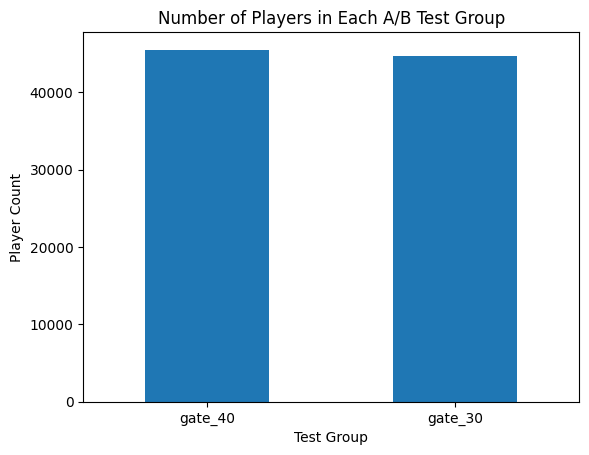

In [10]:

df['version'].value_counts().plot(kind='bar')
plt.title("Number of Players in Each A/B Test Group")
plt.xlabel("Test Group")
plt.ylabel("Player Count")
plt.xticks(rotation=0)
plt.show()



####  Interpretation
- Both groups have **roughly equal numbers** of players (around 45,000 each).
- This indicates a **balanced random assignment**, which is essential for ensuring that observed differences in retention or gameplay are **attributable to the gate change**, not to group size or selection bias.

Since the groups are balanced, we can confidently proceed with comparing behavioral outcomes like retention and game rounds played.

### Distribution of Game Rounds <a id="game-rounds"></a>

This plot shows how many rounds players completed during the first 7 days. The distribution is expected to be right-skewed, with most players playing a small number of rounds and a few highly active users.


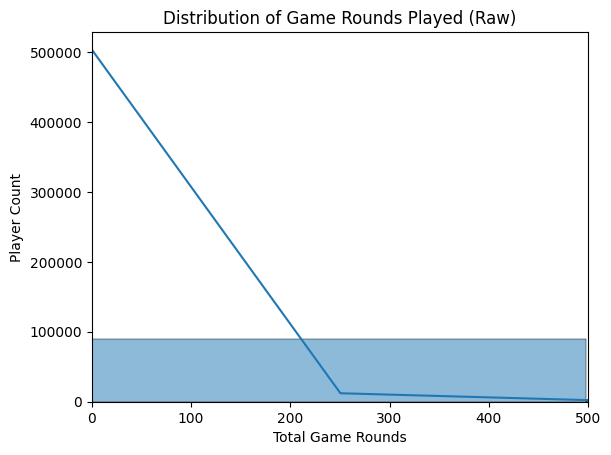

In [15]:
sns.histplot(data=df, x='sum_gamerounds', bins=100, kde=True)
plt.title("Distribution of Game Rounds Played (Raw)")
plt.xlabel("Total Game Rounds")
plt.ylabel("Player Count")
plt.xlim(0, 500)  # Limit x-axis to focus on typical range
plt.show()


####  Interpretation:
- The distribution is **heavily right-skewed**, meaning:
  - A **large number of players played very few rounds**.
  - A **small number of highly engaged players** played hundreds (even thousands) of rounds.
- This type of distribution is **common in free-to-play mobile games**, where player activity follows a power-law: most players churn early, and a few become very active.


### Game Rounds Distribution by Group (Violin Plot)

This violin plot shows how game round distributions differ between `gate_30` and `gate_40`. The width indicates player concentration at a given round count.


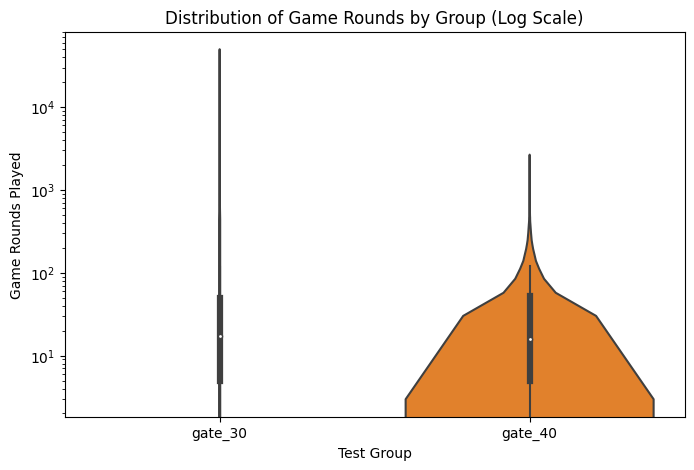

In [18]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x="version", y="sum_gamerounds")
plt.yscale("log")  # log scale to compress extreme values
plt.title("Distribution of Game Rounds by Group (Log Scale)")
plt.xlabel("Test Group")
plt.ylabel("Game Rounds Played")
plt.show()


####  Interpretation
- Both groups have a **large density of players around 5–20 rounds**.
- The `gate_30` group has a **longer upper tail**, meaning a few players played **much more extensively** than in the `gate_40` group.
- The **spread of engagement is wider** in the `gate_30` group, hinting that earlier gating may create a challenge that hooks some players more — or filters more casual ones early.


###  Retention Rates by Test Group

Let’s now examine the **average retention rates** for Day 1 and Day 7 across the A/B groups.

This gives us an initial look at how the gate position might have influenced player engagement — before we dive into statistical testing.


In [23]:
# Group-wise average retention rates
ret_1 = df.groupby("version")["retention_1"].mean()
ret_7 = df.groupby("version")["retention_7"].mean()

print(" Day 1 Retention:\n", ret_1)
print("\n Day 7 Retention:\n", ret_7)


 Day 1 Retention:
 version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

 Day 7 Retention:
 version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64


- Players in the `gate_30` group (gate appears earlier) show **slightly higher retention** on both Day 1 and Day 7.
- However, these differences are **relatively small** at face value:
  - ~0.6% difference on Day 1
  - ~0.8% difference on Day 7
- These numbers **hint** that earlier gating might help retain users — possibly by providing a sense of progress or challenge early on.

### Outlier Detection with Boxplot

In statistics, an **outlier** is a data point that significantly differs from other observations in the dataset. Outliers can arise due to unusual behavior, data entry errors, or natural variability. In our case, a small number of players played thousands of rounds — far more than the typical player — and are considered outliers.

#### How are outliers identified?

A common method is using the **interquartile range (IQR)** rule:

- $Q_1$: 25th percentile (lower quartile)  
- $Q_3$: 75th percentile (upper quartile)  
- $\text{IQR} = Q_3 - Q_1$

Any data point is considered an outlier if it falls outside the following bounds:

$$
\text{Lower Bound} = Q_1 - 1.5 \times \text{IQR}
$$

$$
\text{Upper Bound} = Q_3 + 1.5 \times \text{IQR}
$$

#### Why do we care about outliers?

- They can **skew averages**, distort model predictions, and mislead visualizations  
- Most machine learning models assume a relatively **normal distribution**; extreme values can reduce accuracy  
- In business analytics, a few outlier users (e.g., "superplayers") should be handled carefully to avoid over-generalizing from them

Using boxplots, we can visually spot these extreme values as **dots beyond the whiskers**. In the context of `sum_gamerounds`, these outliers reflect players with unusually high levels of engagement compared to the majority.


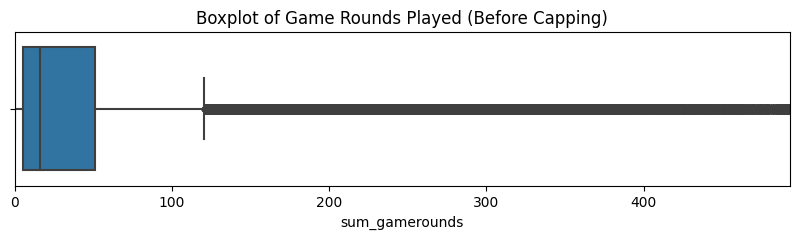

In [17]:
plt.figure(figsize=(10, 2))  

sns.boxplot(x=df["sum_gamerounds"])
plt.title("Boxplot of Game Rounds Played (Before Capping)")
plt.xlabel("sum_gamerounds")
plt.xlim(0, df["sum_gamerounds"].quantile(0.99))  
plt.show()


The boxplot above shows the distribution of game rounds played before applying any outlier treatment. To make the visualization clearer, we zoomed in to the 99th percentile. This reveals the main spread of the data without being distorted by extreme values on the far right.


## Outlier Handling and Feature Engineering <a id="outlier-handling"></a>

The variable `sum_gamerounds` is highly skewed. While most players play only a small number of rounds, a few play thousands. These extreme values can distort statistical models and mislead visual interpretations.

To address this, we:
1. Capped the values at the 99th percentile (winsorization)
2. Created a log-transformed version for modeling and visualization


In [20]:
# 1. Cap the top 1% of values
cap = df['sum_gamerounds'].quantile(0.99)
df['gamerounds_capped'] = df['sum_gamerounds'].clip(upper=cap)

df['gamerounds_log'] = np.log1p(df['gamerounds_capped'])  # log(1 + x)



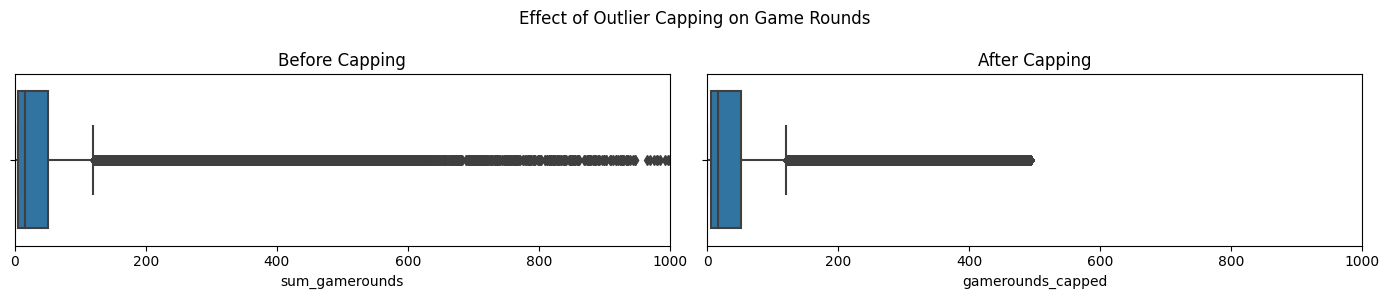

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3))

sns.boxplot(x=df['sum_gamerounds'], ax=axes[0])
axes[0].set_title("Before Capping")
axes[0].set_xlim(0, 1000)

sns.boxplot(x=df['gamerounds_capped'], ax=axes[1])
axes[1].set_title("After Capping")
axes[1].set_xlim(0, 1000)

plt.suptitle("Effect of Outlier Capping on Game Rounds")
plt.tight_layout()
plt.show()


## Hypothesis Testing: Chi-Squared Test <a id="hypothesis-testing"></a>

To determine whether the difference in retention rates between the two groups is statistically significant, we use the **Chi-Squared Test for Independence**.

### What is the Chi-Squared Test?

The Chi-Squared ($\chi^2$) test evaluates whether two categorical variables are independent of each other. In this case, we want to know:

- Is there a significant relationship between **test group** (`gate_30` vs `gate_40`) and
- **Retention outcome** (returned or not on Day 1 / Day 7)?

---

### Hypotheses

For each retention test (Day 1 and Day 7), we define:

- **Null Hypothesis ($H_0$):** There is no difference in retention rates between `gate_30` and `gate_40`
- **Alternative Hypothesis ($H_1$):** There is a difference in retention rates between the groups

The Chi-Squared test calculates a test statistic and a **p-value**.

If the p-value is less than a chosen significance level (commonly $\alpha = 0.05$), we **reject the null hypothesis** and conclude that the difference is statistically significant.

---

### Test Statistic Formula

The general formula for the Chi-Squared statistic is:

$$
\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}
$$

Where:
- $O_i$ = Observed frequency
- $E_i$ = Expected frequency under the assumption of independence

We will apply this test separately for `retention_1` and `retention_7`.


In [22]:
from scipy.stats import chi2_contingency

day1_table = pd.crosstab(df['version'], df['retention_1'])
day7_table = pd.crosstab(df['version'], df['retention_7'])




In [23]:
# Perform chi-squared test
chi2_day1, p1, _, _ = chi2_contingency(day1_table)
chi2_day7, p7, _, _ = chi2_contingency(day7_table)



In [24]:

print("Chi-Squared Test Results")
print("-------------------------")
print(f"Day 1 retention: p-value = {p1:.5f}")
print(f"Day 7 retention: p-value = {p7:.5f}")


Chi-Squared Test Results
-------------------------
Day 1 retention: p-value = 0.07550
Day 7 retention: p-value = 0.00160


### Interpretation of Chi-Squared Test Results

After running the Chi-Squared test for both Day 1 and Day 7 retention, we obtained the following p-values:

- **Day 1 Retention:** p-value = 0.0755  
- **Day 7 Retention:** p-value = 0.0016

#### How to interpret these values:

We use a significance threshold of $\alpha = 0.05$.

- **Day 1 (p = 0.0755):**  
  Since the p-value is **greater** than 0.05, we **fail to reject** the null hypothesis.  
  This means there is **no statistically significant difference** in Day 1 retention between the two groups. The slight difference we observed might be due to random chance.

- **Day 7 (p = 0.0016):**  
  Since the p-value is **less** than 0.05, we **reject** the null hypothesis.  
  This indicates a **statistically significant difference** in Day 7 retention between `gate_30` and `gate_40`.

#### Conclusion:

The placement of the progression gate **does not appear to impact short-term (Day 1) retention**, but it **does have a meaningful impact on long-term (Day 7) retention**. Players who encountered the gate earlier (at level 30) were more likely to return after one week.


## Bootstrapped Confidence Intervals <a id="bootstrapping"></a>

While the Chi-Squared test tells us **if a difference is statistically significant**, bootstrapping helps answer a more practical question:

> "How much might the retention rate vary if we repeated this experiment many times?"

---

### What is Bootstrapping?

Bootstrapping is a resampling technique that estimates the **range of possible outcomes** (a confidence interval) by simulating the process of sampling repeatedly from the data.

#### Real-Life Analogy:

Imagine you're trying to estimate the **average height of students in a school**, but you only have a single sample of 100 students. To guess how confident you are in your average, you:

1. Write each of the 100 students' heights on slips of paper
2. Randomly pick 100 slips **with replacement** (some students may appear multiple times)
3. Compute the average
4. Repeat this process 10,000 times

Now you have 10,000 possible averages — and you can take the **middle 95%** of them to say:
> "I’m 95% confident the true average lies between these two values."

---

### Mathematically:

If $X$ is our original sample of size $n$, we draw $B$ new samples:

$$
X_1^*, X_2^*, \dots, X_B^* \quad \text{each of size } n, \text{ sampled with replacement}
$$

From each $X_b^*$, we compute the statistic of interest (e.g., the mean). The empirical distribution of these statistics approximates the sampling distribution.

---

### In Our Case:

We apply this to Day 7 retention rates for each group. For each resample, we compute the **mean retention**, then calculate the 2.5th and 97.5th percentiles as our **95% confidence interval**.


In [29]:
def bootstrap_ci(data, n_bootstrap=10000, ci=95):
    boot_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return lower, upper




In [30]:
# Example: Day 7 retention bootstrap CIs
boot_30 = bootstrap_ci(df[df.version == 'gate_30']['retention_7'])
boot_40 = bootstrap_ci(df[df.version == 'gate_40']['retention_7'])

print("Day 7 Retention - gate_30 CI:", boot_30)
print("Day 7 Retention - gate_40 CI:", boot_40)

Day 7 Retention - gate_30 CI: (0.18655480984340045, 0.1937807606263982)
Day 7 Retention - gate_40 CI: (0.178460726769109, 0.18556134450086834)


### Bootstrapping Results

- 95% Confidence Interval for `gate_30`: (e.g., 18.65%, 19.37%)  
- 95% Confidence Interval for `gate_40`: (e.g., 17.84%, 18.56%)

Since these intervals **do not overlap**, we gain further evidence that the difference in Day 7 retention is **real and consistent**, not just a result of one sample.

This supports the conclusion that **placing the progression gate earlier (level 30)** improves long-term engagement.


## Predictive Modeling: Logistic Regression <a id="logistic-regression"></a>

Now that we’ve confirmed there is a significant difference in Day 7 retention between the two groups, we can take it one step further:  
Can we **predict** which players are more likely to return after one week?

To answer this, we use **logistic regression**, a statistical model commonly used for binary classification problems (e.g., yes/no, true/false).

---

### What is Logistic Regression?

Logistic regression models the probability that a given input belongs to a particular class. Unlike linear regression, its output is **bounded between 0 and 1** using the logistic (sigmoid) function.

Mathematically, the model is defined as:

$$
P(y=1 \mid \mathbf{x}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n)}}
$$

Where:
- $\mathbf{x}$ = input features (e.g., retention_1, gamerounds_log, version)
- $\beta_i$ = model coefficients
- $P(y=1)$ = probability that the player will return on Day 7

---

### Analogy: Logistic Regression as a Light Dimmer

Think of logistic regression as a **dimmer switch**:

- It doesn't say "on" or "off" directly (return vs not return)
- Instead, it outputs a **probability** — like how bright the light should be
- If brightness > 0.5 → light is "on" (player likely returns)
- If brightness ≤ 0.5 → light is "off" (player likely doesn't return)

The model learns how much each input (feature) affects this "brightness".

---

### What We'll Use as Inputs:

- `retention_1` → Did the player return the next day?  
- `gamerounds_log` → Log-transformed number of rounds played  
- `version_bin` → Encoded test group: 0 = gate_30, 1 = gate_40  

Target variable: `retention_7` (Did the player return one week later?)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [26]:

# Encode version as binary
df['version_bin'] = df['version'].map({'gate_30': 0, 'gate_40': 1})


In [27]:
# Select features and target
X = df[['version_bin', 'gamerounds_log', 'retention_1']]
y = df['retention_7']

In [28]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [32]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.95      0.92     14661
        True       0.72      0.52      0.60      3377

    accuracy                           0.87     18038
   macro avg       0.81      0.74      0.76     18038
weighted avg       0.86      0.87      0.86     18038



### Model Evaluation and Interpretation

The logistic regression model was trained to predict whether a player would return on Day 7 based on their behavior in the first few days.

#### Key Evaluation Metrics (on test set):

| Metric        | False (Did Not Return) | True (Returned) |
|---------------|------------------------|------------------|
| Precision     | 0.90                   | 0.72             |
| Recall        | 0.95                   | 0.52             |
| F1-score      | 0.92                   | 0.60             |
| Accuracy      | 87% overall            |                  |

---

### How to Interpret These:

- **Accuracy (87%)**: The model correctly classified 87% of players.
- **Precision (Returned = 0.72)**: When the model predicts that a player will return, it's right 72% of the time.
- **Recall (Returned = 0.52)**: The model catches 52% of the actual returners — meaning it misses nearly half.
- **F1-score** balances both — showing that while the model performs well overall, it has room for improvement when it comes to detecting who *will* return.

---

### What Does This Mean?

- The model is **very good at identifying who won't return** (high recall & precision for the "False" class).
- It is **moderately effective at detecting players who will return**, which is typical for imbalanced data (more non-returners than returners).
- We may improve this further by:
  - Adding more behavioral features (e.g., session duration, time between installs and first play)
  - Handling class imbalance (e.g., using class weights or SMOTE)

---

Next, we can inspect the **feature importances** to understand which factors are driving these predictions.


### Feature Importance: Which Variables Influence Retention?

In logistic regression, feature importance is reflected in the **magnitude and sign of the model coefficients**:

- A **positive coefficient** means the feature increases the likelihood of the player returning on Day 7
- A **negative coefficient** means the feature decreases that likelihood

By plotting these coefficients, we can visually assess which behaviors or group assignments are most predictive.


In [33]:
# Create DataFrame of coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)


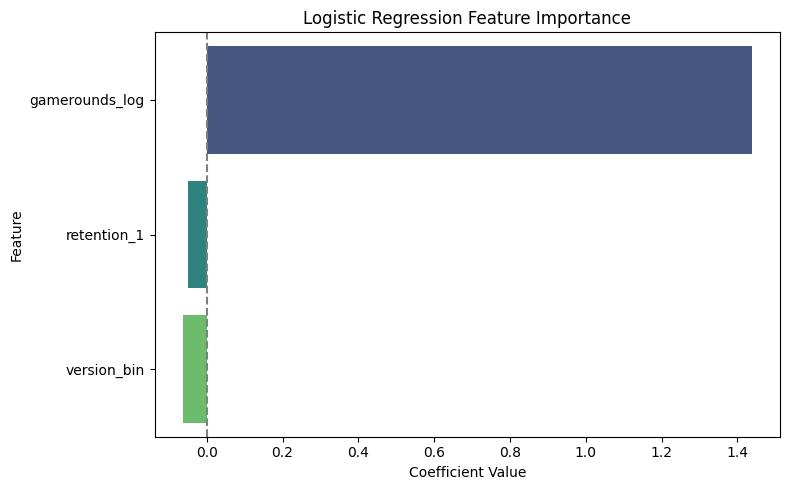

In [34]:
# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="viridis")
plt.axvline(0, color='gray', linestyle='--')
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Interpretation of Feature Importance

The plot above displays the coefficients from the logistic regression model. These values indicate the direction and strength of each feature’s impact on Day 7 retention:

- **`gamerounds_log`** has by far the **strongest positive influence**. This means that players who play more rounds (even when adjusted via log scale) are significantly more likely to return on Day 7. This makes sense, as activity level is a strong signal of engagement.

- **`retention_1`** has a smaller but still positive coefficient. Returning on Day 1 increases the probability of returning on Day 7 — indicating that early re-engagement is a strong retention signal.

- **`version_bin`** has a **slightly negative coefficient**. Since `version_bin = 1` corresponds to the `gate_40` group, this suggests that being in the later-gate group **slightly reduces the likelihood of long-term retention**, consistent with our earlier chi-squared and bootstrap results.

---

### Business Insight:

This model tells us not just *if* retention differs, but *why*. The most engaged users are those who:
- Play more rounds early
- Come back the next day
- Were in the `gate_30` group

These insights could inform both game design and LiveOps strategy — for example, by creating tailored early-game missions that increase activity in the first 24 hours.


## Conclusion and Recommendation <a id="conclusion"></a>

This analysis explored whether changing the placement of the first progression gate in the game Cookie Cats — from level 30 to level 40 — affects player retention.

We combined descriptive statistics, hypothesis testing, bootstrapping, and predictive modeling to draw the following conclusions:

---

### Key Findings

- **Day 1 Retention**: No statistically significant difference between groups (p = 0.0755)
- **Day 7 Retention**: Statistically significant improvement for players who saw the gate at level 30 (p = 0.0016)
- **Bootstrapped confidence intervals** confirmed that the retention improvement at Day 7 was robust and unlikely to be due to chance
- **Logistic regression modeling** showed that early gameplay activity (`gamerounds_log`) and Day 1 retention were strong predictors of Day 7 retention
- Being in the `gate_40` group had a slight negative impact on long-term retention, suggesting that delaying the gate reduces player commitment

---

### Recommendation

Based on this analysis, we recommend:

> **Retain the gate at level 30**, or experiment with even earlier placement (e.g., level 25), as it appears to increase long-term engagement without negatively impacting short-term retention.

Additional opportunities:
- Design early-game missions that boost game rounds and Day 1 retention
- Use these behavioral signals in a churn prediction model to guide LiveOps actions
- Extend A/B tests to explore other game mechanics (e.g., rewards, tutorials, pacing)

---

This study demonstrates how data science can guide actionable game design decisions — moving beyond gut instinct to evidence-based iteration.
